In [14]:
import argparse
import time
import sys
import os
from pathlib import Path
import mlflow
import mlflow.pytorch
from sklearn.metrics import roc_auc_score
import numpy as np

# Add project root to path BEFORE importing from src
# project_root = Path(__file__).resolve().parents[1]
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

# Now import from src
import segmentation_models_pytorch as smp
import torch
import tqdm
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from src.data.datasets import SimpleIberFireSegmentationDataset


In [15]:
model_name = "resnet34_v5.pth"
model_path = project_root / "models" / model_name


In [16]:
# load model
# Setup
import sys
from pathlib import Path
import segmentation_models_pytorch as smp
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

ZARR_PATH = project_root / "data" / "gold" / "IberFire_coarse32_time1.zarr"
from src.data.datasets import SimpleIberFireSegmentationDataset
from torch.utils.data import DataLoader

if True:
        feature_vars = [
            # Dynamic features (time-dependent)
            "FAPAR",
            "FWI",
            "LAI",
            "LST",
            "NDVI",
            "RH_max",
            "RH_mean",
            "RH_min",
            "RH_range",
            "SWI_001",
            "SWI_005",
            "SWI_010",
            "SWI_020",
            "is_holiday",
            "is_near_fire",
            "surface_pressure_max",
            "surface_pressure_mean",
            "surface_pressure_min",
            "surface_pressure_range",
            "t2m_max",
            "t2m_mean",
            "t2m_min",
            "t2m_range",
            "total_precipitation_mean",
            "wind_direction_at_max_speed",
            "wind_direction_mean",
            "wind_speed_max",
            "wind_speed_mean",
            # CLC Level-3 classes (year-aware bases)
            "CLC_1",
            "CLC_2",
            "CLC_3",
            "CLC_4",
            "CLC_5",
            "CLC_6",
            "CLC_7",
            "CLC_8",
            "CLC_9",
            "CLC_10",
            "CLC_11",
            "CLC_12",
            "CLC_13",
            "CLC_14",
            "CLC_15",
            "CLC_16",
            "CLC_17",
            "CLC_18",
            "CLC_19",
            "CLC_20",
            "CLC_21",
            "CLC_22",
            "CLC_23",
            "CLC_24",
            "CLC_25",
            "CLC_26",
            "CLC_27",
            "CLC_28",
            "CLC_29",
            "CLC_30",
            "CLC_31",
            "CLC_32",
            "CLC_33",
            "CLC_34",
            "CLC_35",
            "CLC_36",
            "CLC_37",
            "CLC_38",
            "CLC_39",
            "CLC_40",
            "CLC_41",
            "CLC_42",
            "CLC_43",
            "CLC_44",
            # CLC aggregated proportions (year-aware bases)
            "CLC_agricultural_proportion",
            "CLC_arable_land_proportion",
            "CLC_artificial_proportion",
            "CLC_artificial_vegetation_proportion",
            "CLC_forest_and_semi_natural_proportion",
            "CLC_forest_proportion",
            "CLC_heterogeneous_agriculture_proportion",
            "CLC_industrial_proportion",
            "CLC_inland_waters_proportion",
            "CLC_inland_wetlands_proportion",
            "CLC_marine_waters_proportion",
            "CLC_maritime_wetlands_proportion",
            "CLC_mine_proportion",
            "CLC_open_space_proportion",
            "CLC_permanent_crops_proportion",
            "CLC_scrub_proportion",
            "CLC_urban_fabric_proportion",
            "CLC_waterbody_proportion",
            "CLC_wetlands_proportion",
            # Other static features
            "aspect_1",
            "aspect_2",
            "aspect_3",
            "aspect_4",
            "aspect_5",
            "aspect_6",
            "aspect_7",
            "aspect_8",
            "aspect_NODATA",
            "dist_to_railways_mean",
            "dist_to_railways_stdev",
            "dist_to_roads_mean",
            "dist_to_roads_stdev",
            "dist_to_waterways_mean",
            "dist_to_waterways_stdev",
            "elevation_mean",
            "elevation_stdev",
            "is_natura2000",
            "is_sea",
            "is_spain",
            "is_waterbody",
            "roughness_mean",
            "roughness_stdev",
            "slope_mean",
            "slope_stdev",
            # Year-aware population density (popdens_YYYY family)
            "popdens",
        ]

in_channels = len(feature_vars)

####

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,        
    in_channels=in_channels,
    classes=1,
    activation=None,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load the checkpoint (new format: state dict only, no epoch/optimizer info)
checkpoint = torch.load(model_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)



<All keys matched successfully>

[SimpleDataset] Opening Zarr dataset: /Users/vladimir/catalonia-wildfire-prediction/data/gold/IberFire_coarse32_time1.zarr
[SimpleDataset] Filtering time range: 2021-01-01 to 2021-12-31
[SimpleDataset] Total usable time steps: 365
[SimpleDataset] Time steps after mode='all': 365
[SimpleDataset] Dynamic vars (time-dependent): ['FAPAR', 'FWI', 'LAI', 'LST', 'NDVI', 'RH_max', 'RH_mean', 'RH_min', 'RH_range', 'SWI_001', 'SWI_005', 'SWI_010', 'SWI_020', 'is_holiday', 'is_near_fire', 'surface_pressure_max', 'surface_pressure_mean', 'surface_pressure_min', 'surface_pressure_range', 't2m_max', 't2m_mean', 't2m_min', 't2m_range', 'total_precipitation_mean', 'wind_direction_at_max_speed', 'wind_direction_mean', 'wind_speed_max', 'wind_speed_mean']
[SimpleDataset] Static vars (no time dimension, broadcast in time): ['aspect_1', 'aspect_2', 'aspect_3', 'aspect_4', 'aspect_5', 'aspect_6', 'aspect_7', 'aspect_8', 'aspect_NODATA', 'dist_to_railways_mean', 'dist_to_railways_stdev', 'dist_to_roads_mean

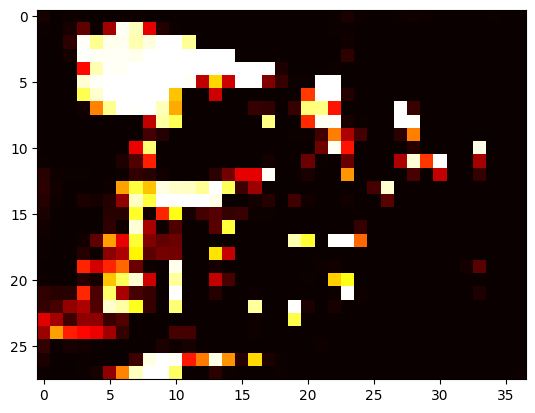

In [17]:
import matplotlib.pyplot as plt
test_ds = SimpleIberFireSegmentationDataset(
    zarr_path=ZARR_PATH,
    time_start="2021-01-01",
    time_end="2021-12-31",
    feature_vars=feature_vars,
    label_var="is_near_fire",
    spatial_downsample=1,
    lead_time=1,
    compute_stats=False,
    stats_path=project_root / "stats" / "simple_iberfire_stats_train.json"
)
X, y = test_ds[0]
X = X.unsqueeze(0).to(device).float()
model.eval()
with torch.no_grad():
    out = model(X)
    probs = torch.sigmoid(out).cpu().numpy()
image = probs[0, 0, :, :]
plt.imshow(image, cmap="hot")
print("Loaded model output shape:", out.shape)

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def compare_prediction(model, ds, date_str: str):
    """
    Show model prediction for a given date with ground-truth fire mask overlaid.
    Prediction: blue-red heatmap, Label: transparent red mask.
    """
    # 1) Find index for the requested date
    idx = None
    for i in range(len(ds)):
        t = ds.get_time_value(i)  # assumes np.datetime64 or similar
        if str(t)[:10] == date_str:
            idx = i
            break

    if idx is None:
        print(f"No sample found for date {date_str}")
        return

    print(f"Using sample index {idx} for date {date_str}")

    # 2) Get data and run model
    X, y = ds[idx]            # X: [C,H,W], y: [1,H,W]
    X_batch = X.unsqueeze(0).to(device).float()

    model.eval()
    with torch.no_grad():
        logits = model(X_batch)    # [1,1,H,W]
        probs = torch.sigmoid(logits).cpu().squeeze().numpy()  # [H,W]

    target = y.squeeze().numpy()   # [H,W], 0/1

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    # Base: prediction heatmap (blue-red)
    im_pred = ax.imshow(
        probs,
        cmap="bwr",
        vmin=0.0,
        vmax=1.0,
        origin="lower",
    )
    plt.colorbar(im_pred, ax=ax, fraction=0.046, pad=0.04, label="Predicted prob")

    # Overlay: ground-truth mask as transparent red
    # ensure mask is 0/1
    mask = (target > 0.5).astype(float)
    # use alpha mask so only fire pixels are visible
    im_gt = ax.imshow(
        np.ma.masked_where(mask == 0, mask),
        cmap="Reds",
        vmin=0.0,
        vmax=1.0,
        origin="lower",
        alpha=0.6,   # transparency of label overlay
    )

    ax.set_title(f"Predicted wildfire probability heatmap VS. real fires (squares)\n for Spain on {date_str}")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

Using sample index 306 for date 2021-11-03


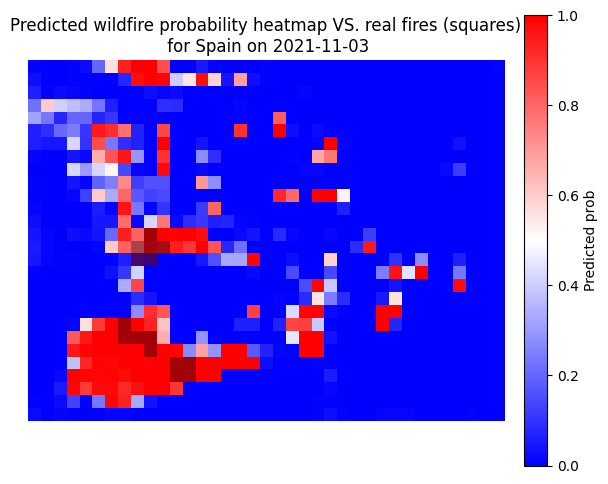

In [24]:
compare_prediction(model, test_ds, "2021-11-03")